In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [9]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

<h1> BiLSTM1 - BiGRU1 </h1>

In [10]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 128, 256)          141312    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [11]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 15s 63ms/step - loss: 1.1156 - accuracy: 0.5331 - val_loss: 0.7729 - val_accuracy: 0.6704
Epoch 2/10
58/58 [==============================] - 2s 39ms/step - loss: 0.6326 - accuracy: 0.7421 - val_loss: 0.3888 - val_accuracy: 0.8645
Epoch 3/10
58/58 [==============================] - 2s 40ms/step - loss: 0.4375 - accuracy: 0.8345 - val_loss: 0.3248 - val_accuracy: 0.8867
Epoch 4/10
58/58 [==============================] - 2s 40ms/step - loss: 0.2546 - accuracy: 0.9104 - val_loss: 0.4787 - val_accuracy: 0.8663
Epoch 5/10
58/58 [==============================] - 2s 40ms/step - loss: 0.2463 - accuracy: 0.9085 - val_loss: 0.1456 - val_accuracy: 0.9519
Epoch 6/10
58/58 [==============================] - 2s 40ms/step - loss: 0.1500 - accuracy: 0.9434 - val_loss: 0.1317 - val_accuracy: 0.9465
Epoch 7/10
58/58 [==============================] - 2s 39ms/step - loss: 0.1334 - accuracy: 0.9478 - val_loss: 0.1125 - val_accuracy: 0.9524
Epoch 8/10
5

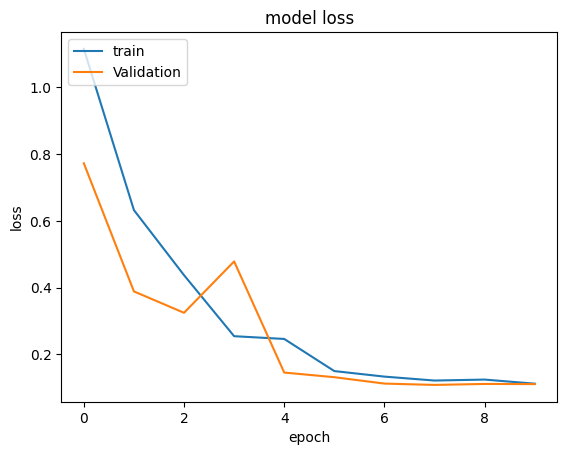

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

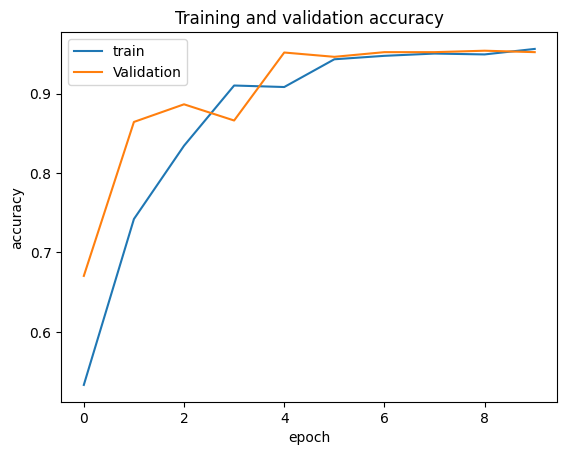

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 10ms/step
[[450  18  28   0   0   0]
 [ 19 417  35   0   0   0]
 [  0   1 419   0   0   0]
 [  2   4   1 369 115   0]
 [  4   0   0  54 474   0]
 [  0  28   0   0   0 509]]
0.8951476077366813
0.8947432789885202
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       496
           1       0.89      0.89      0.89       471
           2       0.87      1.00      0.93       420
           3       0.87      0.75      0.81       491
           4       0.80      0.89      0.85       532
           5       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.89      2947
weighted avg       0.90      0.90      0.89      2947



<Axes: >

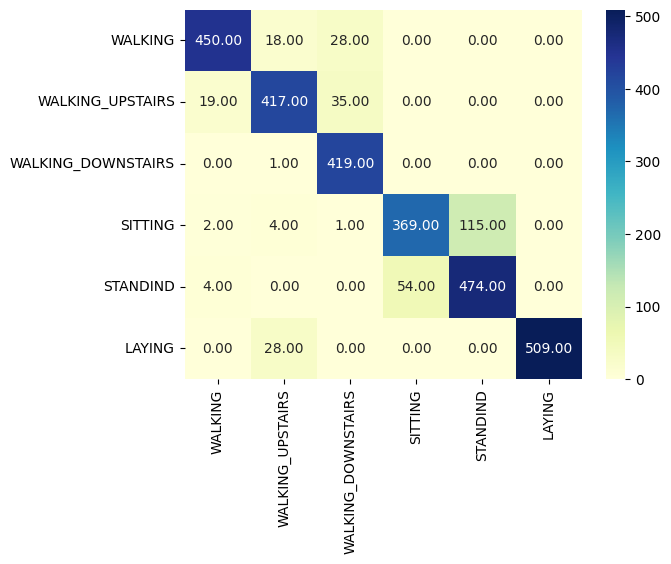

In [14]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM2 - BiGRU1 </h1>

In [15]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 128, 256)          141312    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 128, 256)          394240    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                      

In [16]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 17s 123ms/step - loss: 1.0480 - accuracy: 0.5525 - val_loss: 0.7047 - val_accuracy: 0.7103
Epoch 2/10
58/58 [==============================] - 4s 64ms/step - loss: 0.5667 - accuracy: 0.7658 - val_loss: 0.5296 - val_accuracy: 0.7792
Epoch 3/10
58/58 [==============================] - 4s 64ms/step - loss: 0.4834 - accuracy: 0.8141 - val_loss: 0.3831 - val_accuracy: 0.8509
Epoch 4/10
58/58 [==============================] - 4s 69ms/step - loss: 0.3056 - accuracy: 0.8833 - val_loss: 0.2881 - val_accuracy: 0.8953
Epoch 5/10
58/58 [==============================] - 4s 65ms/step - loss: 0.2241 - accuracy: 0.9169 - val_loss: 0.1609 - val_accuracy: 0.9433
Epoch 6/10
58/58 [==============================] - 5s 85ms/step - loss: 0.1594 - accuracy: 0.9399 - val_loss: 0.1900 - val_accuracy: 0.9202
Epoch 7/10
58/58 [==============================] - 4s 69ms/step - loss: 0.1640 - accuracy: 0.9357 - val_loss: 0.1589 - val_accuracy: 0.9356
Epoch 8/10


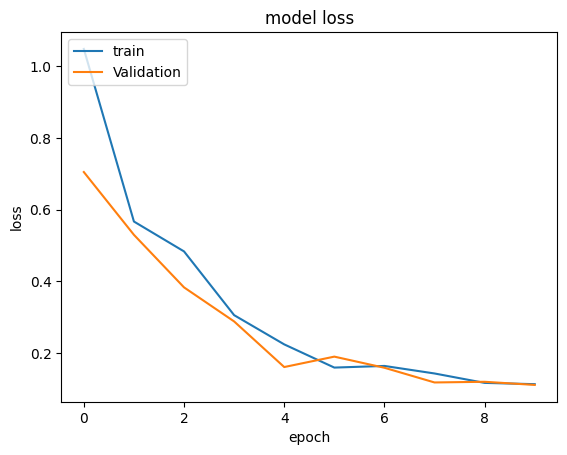

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

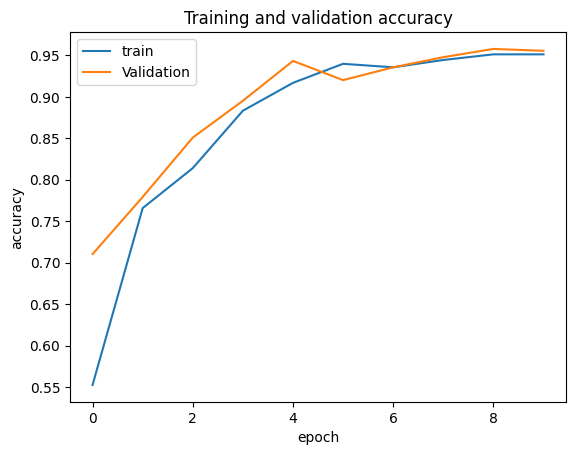

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 3s 13ms/step
[[456  11  26   1   2   0]
 [ 28 442   1   0   0   0]
 [  2   0 416   1   1   0]
 [  0  21   0 387  80   3]
 [  0  10   0  78 444   0]
 [  0  27   0   0   0 510]]
0.9009161859518154
0.9005772865720095
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       496
           1       0.86      0.94      0.90       471
           2       0.94      0.99      0.96       420
           3       0.83      0.79      0.81       491
           4       0.84      0.83      0.84       532
           5       0.99      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



<Axes: >

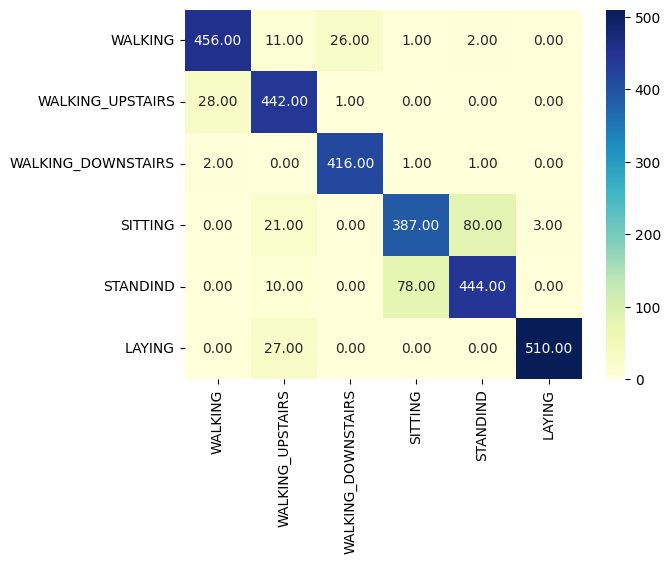

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM1 - BiGRU2 </h1>

In [20]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirecti  (None, 128, 256)          141312    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_6 (Bidirecti  (None, 128, 256)          296448    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                      

In [21]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 16s 96ms/step - loss: 1.1111 - accuracy: 0.5227 - val_loss: 0.7456 - val_accuracy: 0.6985
Epoch 2/10
58/58 [==============================] - 4s 68ms/step - loss: 0.5892 - accuracy: 0.7587 - val_loss: 0.4203 - val_accuracy: 0.8490
Epoch 3/10
58/58 [==============================] - 4s 67ms/step - loss: 0.3508 - accuracy: 0.8766 - val_loss: 0.2590 - val_accuracy: 0.8957
Epoch 4/10
58/58 [==============================] - 4s 67ms/step - loss: 0.2338 - accuracy: 0.9151 - val_loss: 0.1888 - val_accuracy: 0.9302
Epoch 5/10
58/58 [==============================] - 4s 68ms/step - loss: 0.1577 - accuracy: 0.9377 - val_loss: 0.2086 - val_accuracy: 0.9121
Epoch 6/10
58/58 [==============================] - 4s 63ms/step - loss: 0.1552 - accuracy: 0.9408 - val_loss: 0.1306 - val_accuracy: 0.9519
Epoch 7/10
58/58 [==============================] - 4s 63ms/step - loss: 0.1391 - accuracy: 0.9453 - val_loss: 0.1410 - val_accuracy: 0.9406
Epoch 8/10
5

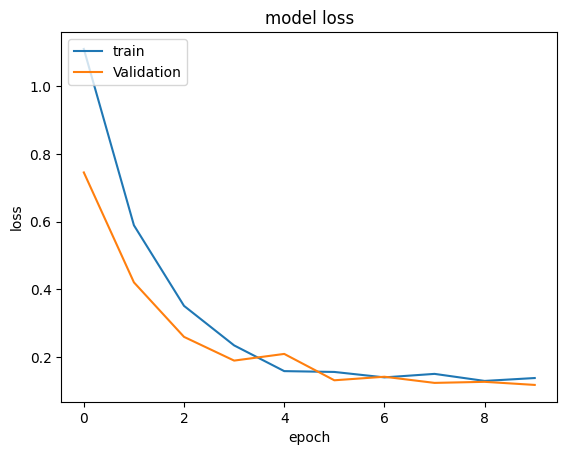

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

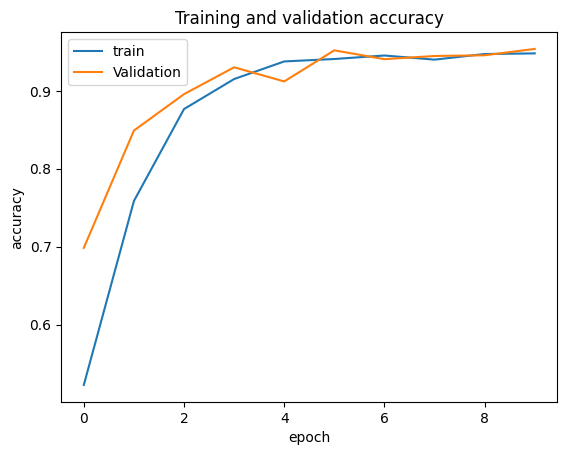

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 3s 13ms/step
[[467   6  23   0   0   0]
 [ 53 392  26   0   0   0]
 [ 11  17 392   0   0   0]
 [  0  19   0 377  95   0]
 [  5   0   0  76 451   0]
 [  0  27   0   0   0 510]]
0.8785205293518833
0.8781862317084508
              precision    recall  f1-score   support

           0       0.87      0.94      0.91       496
           1       0.85      0.83      0.84       471
           2       0.89      0.93      0.91       420
           3       0.83      0.77      0.80       491
           4       0.83      0.85      0.84       532
           5       1.00      0.95      0.97       537

    accuracy                           0.88      2947
   macro avg       0.88      0.88      0.88      2947
weighted avg       0.88      0.88      0.88      2947



<Axes: >

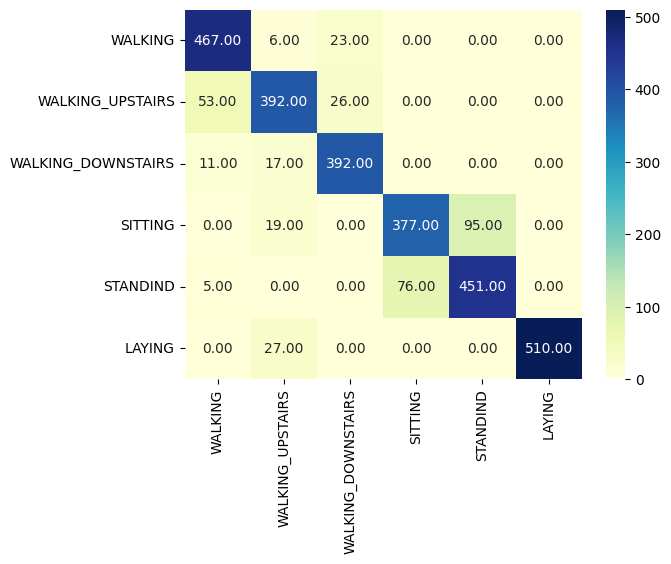

In [24]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM2 - BiGRU2 </h1>

In [25]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirecti  (None, 128, 256)          141312    
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_9 (Bidirecti  (None, 128, 256)          394240    
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_10 (Bidirect  (None, 128, 256)          296448    
 ional)                                                          
                                                      

In [26]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 22s 150ms/step - loss: 1.0382 - accuracy: 0.5630 - val_loss: 0.7465 - val_accuracy: 0.6904
Epoch 2/10
58/58 [==============================] - 5s 87ms/step - loss: 0.5778 - accuracy: 0.7558 - val_loss: 0.4155 - val_accuracy: 0.8586
Epoch 3/10
58/58 [==============================] - 5s 88ms/step - loss: 0.3303 - accuracy: 0.8784 - val_loss: 0.2037 - val_accuracy: 0.9293
Epoch 4/10
58/58 [==============================] - 5s 89ms/step - loss: 0.2087 - accuracy: 0.9240 - val_loss: 0.1661 - val_accuracy: 0.9438
Epoch 5/10
58/58 [==============================] - 5s 88ms/step - loss: 0.1608 - accuracy: 0.9378 - val_loss: 0.1445 - val_accuracy: 0.9316
Epoch 6/10
58/58 [==============================] - 5s 90ms/step - loss: 0.1570 - accuracy: 0.9370 - val_loss: 0.1183 - val_accuracy: 0.9519
Epoch 7/10
58/58 [==============================] - 5s 91ms/step - loss: 0.1385 - accuracy: 0.9463 - val_loss: 0.1332 - val_accuracy: 0.9433
Epoch 8/10


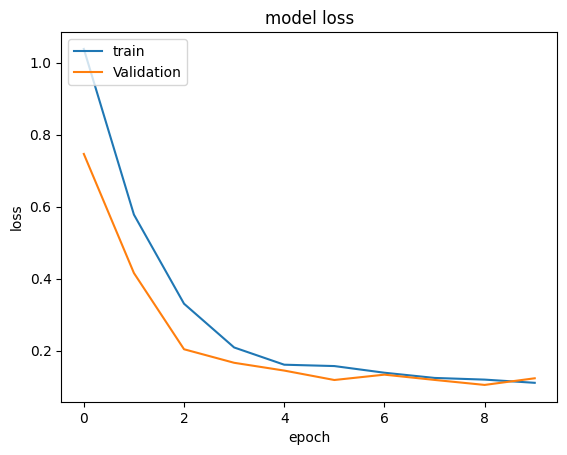

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

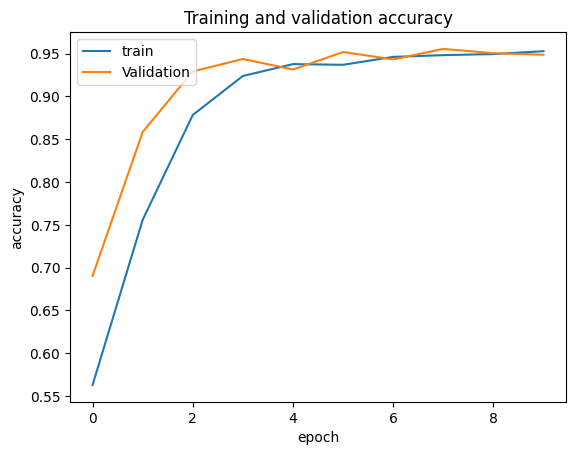

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 5s 17ms/step
[[474   4  18   0   0   0]
 [ 13 446  12   0   0   0]
 [  0   2 418   0   0   0]
 [  0   5   1 368 117   0]
 [  1   2   0  52 477   0]
 [  0   0   0   0   0 537]]
0.9229725144214456
0.9223193238268628
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       496
           1       0.97      0.95      0.96       471
           2       0.93      1.00      0.96       420
           3       0.88      0.75      0.81       491
           4       0.80      0.90      0.85       532
           5       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



<Axes: >

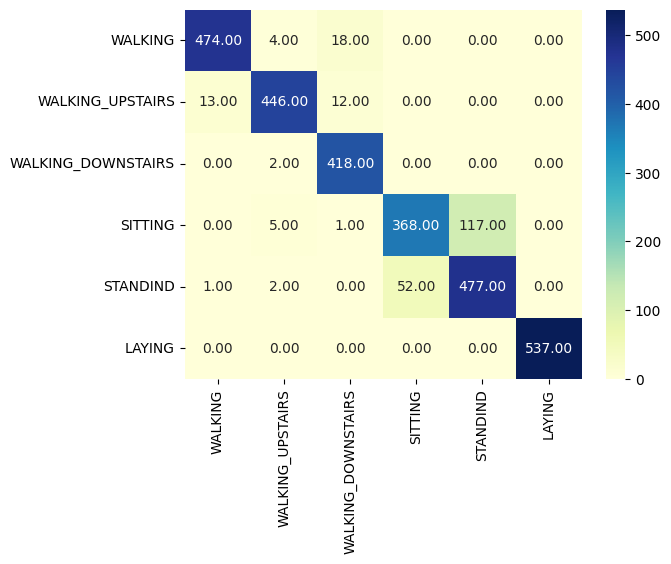

In [29]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM2 - BiGRU2 (Crossed)</h1>

In [30]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirect  (None, 128, 256)          141312    
 ional)                                                          
                                                                 
 dropout_12 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_13 (Bidirect  (None, 128, 256)          296448    
 ional)                                                          
                                                                 
 dropout_13 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_14 (Bidirect  (None, 128, 256)          394240    
 ional)                                                          
                                                      

In [31]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 22s 155ms/step - loss: 1.1003 - accuracy: 0.5331 - val_loss: 0.7736 - val_accuracy: 0.6727
Epoch 2/10
58/58 [==============================] - 5s 90ms/step - loss: 0.8224 - accuracy: 0.6442 - val_loss: 0.6678 - val_accuracy: 0.7053
Epoch 3/10
58/58 [==============================] - 5s 91ms/step - loss: 0.5781 - accuracy: 0.7520 - val_loss: 0.6927 - val_accuracy: 0.6976
Epoch 4/10
58/58 [==============================] - 5s 90ms/step - loss: 0.4026 - accuracy: 0.8530 - val_loss: 0.3498 - val_accuracy: 0.8799
Epoch 5/10
58/58 [==============================] - 5s 90ms/step - loss: 0.2371 - accuracy: 0.9151 - val_loss: 0.2349 - val_accuracy: 0.9275
Epoch 6/10
58/58 [==============================] - 5s 93ms/step - loss: 0.2101 - accuracy: 0.9278 - val_loss: 0.1908 - val_accuracy: 0.9261
Epoch 7/10
58/58 [==============================] - 5s 92ms/step - loss: 0.1703 - accuracy: 0.9363 - val_loss: 0.1333 - val_accuracy: 0.9538
Epoch 8/10


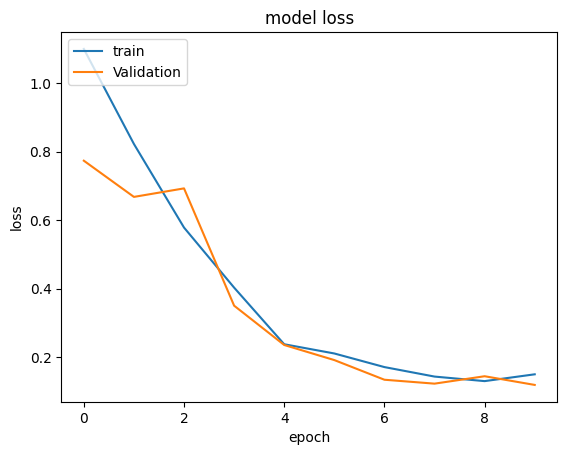

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

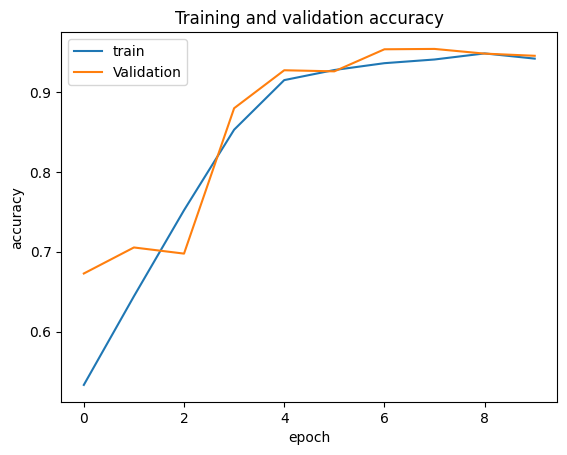

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 5s 18ms/step
[[441  26  29   0   0   0]
 [ 16 436  19   0   0   0]
 [  1   1 418   0   0   0]
 [ 16   3   0 380  86   6]
 [  5   0   0 103 424   0]
 [  0   0   0   0   0 537]]
0.8944689514760774
0.8935879217029176
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       496
           1       0.94      0.93      0.93       471
           2       0.90      1.00      0.94       420
           3       0.79      0.77      0.78       491
           4       0.83      0.80      0.81       532
           5       0.99      1.00      0.99       537

    accuracy                           0.89      2947
   macro avg       0.89      0.90      0.89      2947
weighted avg       0.89      0.89      0.89      2947



<Axes: >

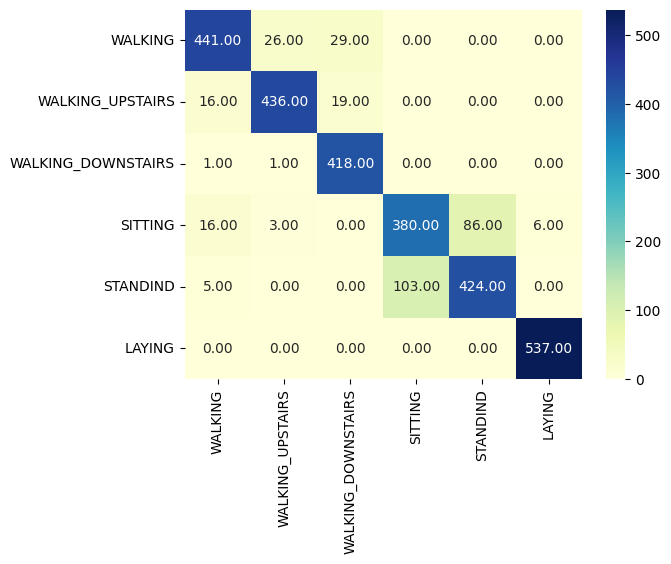

In [34]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM3 - BiGRU3 </h1>

In [35]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_16 (Bidirect  (None, 128, 256)          141312    
 ional)                                                          
                                                                 
 dropout_16 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_17 (Bidirect  (None, 128, 256)          394240    
 ional)                                                          
                                                                 
 dropout_17 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_18 (Bidirect  (None, 128, 256)          394240    
 ional)                                                          
                                                      

In [36]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 31s 201ms/step - loss: 1.0171 - accuracy: 0.5622 - val_loss: 0.9637 - val_accuracy: 0.5766
Epoch 2/10
58/58 [==============================] - 8s 136ms/step - loss: 0.5130 - accuracy: 0.8006 - val_loss: 0.4267 - val_accuracy: 0.8518
Epoch 3/10
58/58 [==============================] - 8s 136ms/step - loss: 0.2964 - accuracy: 0.8950 - val_loss: 0.2099 - val_accuracy: 0.9261
Epoch 4/10
58/58 [==============================] - 8s 137ms/step - loss: 0.2243 - accuracy: 0.9181 - val_loss: 0.1746 - val_accuracy: 0.9297
Epoch 5/10
58/58 [==============================] - 8s 146ms/step - loss: 0.1650 - accuracy: 0.9391 - val_loss: 0.1720 - val_accuracy: 0.9293
Epoch 6/10
58/58 [==============================] - 8s 146ms/step - loss: 0.1511 - accuracy: 0.9402 - val_loss: 0.1258 - val_accuracy: 0.9565
Epoch 7/10
58/58 [==============================] - 8s 147ms/step - loss: 0.1355 - accuracy: 0.9450 - val_loss: 0.1244 - val_accuracy: 0.9501
Epoch

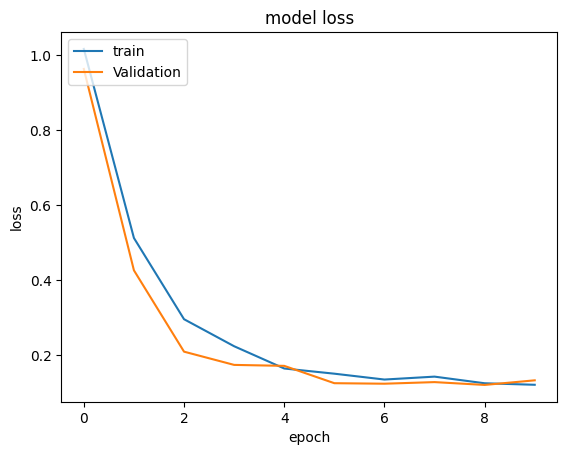

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

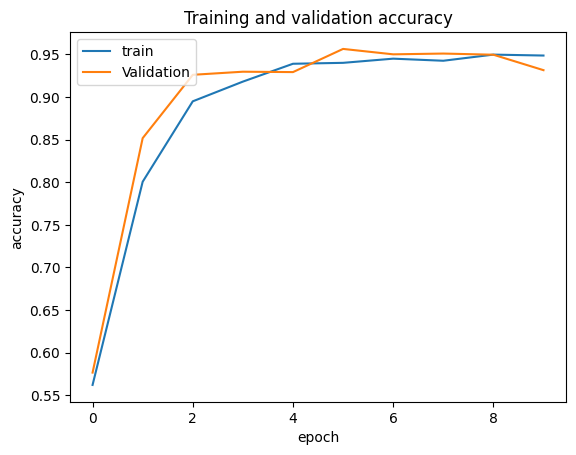

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 6s 24ms/step
[[467   1  28   0   0   0]
 [ 23 433  15   0   0   0]
 [  0   0 420   0   0   0]
 [  1   3   2 273 208   4]
 [  4   0   0  22 506   0]
 [  0   0   0   0   0 537]]
0.8944689514760774
0.8902282355016629
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       496
           1       0.99      0.92      0.95       471
           2       0.90      1.00      0.95       420
           3       0.93      0.56      0.69       491
           4       0.71      0.95      0.81       532
           5       0.99      1.00      1.00       537

    accuracy                           0.89      2947
   macro avg       0.91      0.89      0.89      2947
weighted avg       0.91      0.89      0.89      2947



<Axes: >

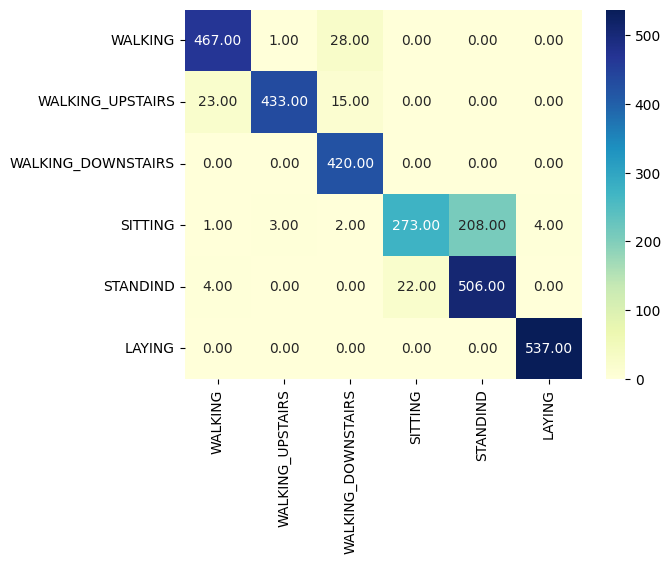

In [39]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')